<a href="https://colab.research.google.com/github/sumukhbhat12/Tensor-Flow-Course-FreeCodeCamp/blob/main/Cats_vs_Dogs_classification_using_Pretrained_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds

A large set of images of cats and dogs.

Dataset: https://www.tensorflow.org/datasets/catalog/cats_vs_dogs

80% training, 10% validation and 10% testing

In [2]:
(raw_train, raw_validation, raw_test), metadata = tfds.load('cats_vs_dogs',
                                                            split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
                                                            with_info=True,
                                                            as_supervised=True
                                                            )

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/4.0.0.incomplete32GPBU/cats_vs_dogs-train.tfrecord*...:   0%|…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.0. Subsequent calls will reuse this data.


In [3]:
get_label_name = metadata.features['label'].int2str   # creates a function object we can use to get labels

display 2 images from the dataset

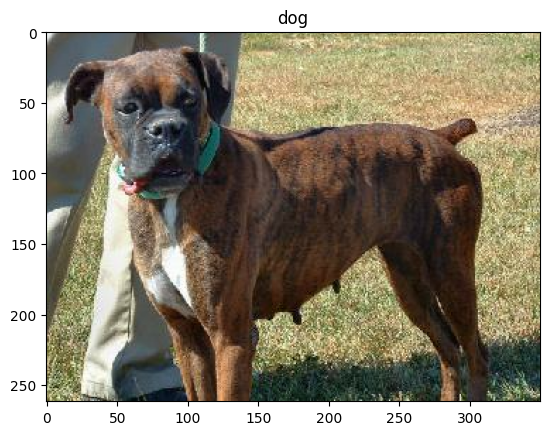

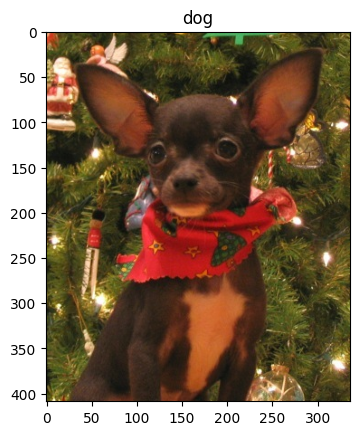

In [4]:
for image, label in raw_train.take(2):
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

Scale the images to the same size

In [5]:
IMG_SIZE = 160    # all images will be resized to 160x160

In [6]:
def format_resize(image, label):
  # returns an image resized to IMG_SIZE
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1   # normalize pixel values between -1,1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label

In [7]:
train = raw_train.map(format_resize)
validation = raw_validation.map(format_resize)
test = raw_test.map(format_resize)

Shuffle and make batches

In [8]:
train

<_MapDataset element_spec=(TensorSpec(shape=(160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [10]:
train_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

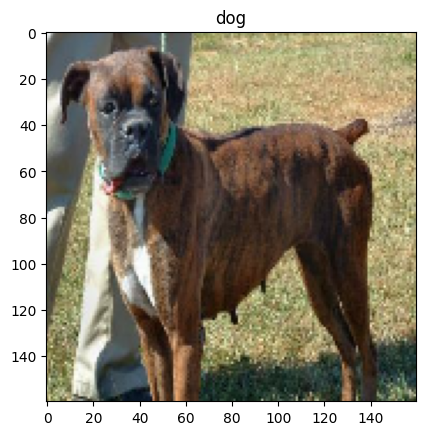

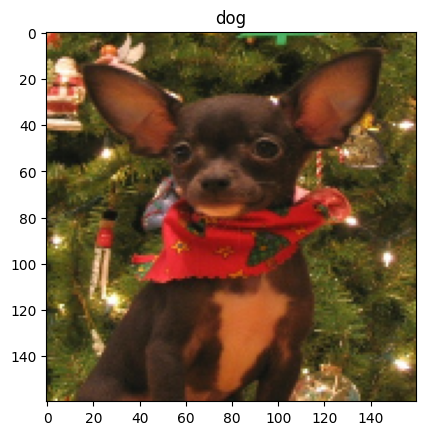

In [11]:
for image, label in train.take(2):
  plt.figure()
  plt.imshow((image + 1) * 127.5 / 255.0)
  plt.title(get_label_name(label))

picking the pretrained model

The model we are going to use as the convolutional base for our model is the MobileNetV2 developed at Google. This model is trained on 1.4 million images and has 1000 different classes.

In [12]:
IMG_SHAPE = ( IMG_SIZE, IMG_SIZE, 3)

include_top is False because we are only using the convolution base and hence not loading the top layers.

In [13]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

9406464/9406464 [==============================] - 0s 0us/step


output shape is (None, 5, 5, 1280)

In [ ]:
# base_model.summary()

Freezing the base

freezing refers to disabling the training property of a layer, we need to freeze the base because we don't want to change the convolutional base that already has learned weights

In [15]:
base_model.trainable = False

Adding our Classifier

instead of flattening the feature map of the base layer, we will use a global average pooling layer that will average the entire 5x5 area of each 2D feature map and return to us a single 1280 element vector per filter

In [16]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

add the dense layer to predict the output

In [17]:
prediction_layer = tf.keras.layers.Dense(1)

combine everything into a model

In [18]:
model = tf.keras.Sequential([
    base_model,
    global_average_layer,
    prediction_layer
])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


Training the model

In [20]:
base_learning_rate = 0.0001

In [21]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

to check how the model performs before training it on our images

In [22]:
validation_batches

<_BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [23]:
_, accuracy = model.evaluate(validation_batches, steps = 20)

20/20 [==============================] - 16s 694ms/step - loss: 0.7746 - accuracy: 0.5031


Training the model on our images

takes ~25 minutes

gives accuracy of 97.92% and validation accuracy of 97.94%

In [30]:
history = model.fit(
    train_batches,
    epochs=3,
    validation_data=validation_batches
)

Epoch 1/3
582/582 [==============================] - 467s 795ms/step - loss: 0.2038 - accuracy: 0.9098 - val_loss: 0.0864 - val_accuracy: 0.9690
Epoch 2/3
582/582 [==============================] - 484s 827ms/step - loss: 0.0693 - accuracy: 0.9758 - val_loss: 0.0637 - val_accuracy: 0.9751
Epoch 3/3
582/582 [==============================] - 464s 794ms/step - loss: 0.0562 - accuracy: 0.9792 - val_loss: 0.0563 - val_accuracy: 0.9794


saving and loading as shown below doesn't work after colab notebook restart

In [25]:
# model.save('dogs_vs_cats.h5')

In [34]:
# new_model = tf.keras.models.load_model('dogs_vs_cats.h5')

In [35]:
# new_model.evaluate(validation_batches, steps=20)